In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from argparse import Namespace
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [4]:
tweet= pd.read_csv('train.csv')

tweet.head(5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:

test=pd.read_csv('test_default.csv')
x=0
for idx, row in test.iterrows():
        x+=1
        test.loc[idx,'id'] = x
test = test.drop(['Unnamed: 0'], axis = 1)
test = test.rename(columns={'tweet': 'text'})
test.to_csv('test123.csv',index=False)


In [6]:
test=pd.read_csv('test123.csv')

test.head(5)

,id,keyword,location,text
0,1,typhoon,MISSISSIPPI,You cant help but be honest and opinionated wh...
1,2,earthquake,"💯personal, reikableu-all SNS",Was that my imagination only? Or was it an #ea...
2,3,arsonist,"Victoria, Australia","The time for fire reduction burns is limited, ..."
3,4,arson,"Washington, DC","No, we like arson"
4,5,earthquake,euphoria ♡,"yeah, I heard there was an earthquake but I di..."


In [7]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3000 rows and 4 columns in test


Text(0, 0.5, 'samples')

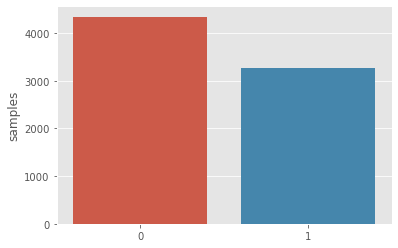

In [8]:
#train data
#Before we begin with anything else,let's check the class distribution.
#There are only two classes 0 and 1.
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
#ohh,as expected ! There is a class distribution.
#There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

#train data
#First,we will do very basic analysis,that is character level,
#word level and sentence level analysis.
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

#train data
#Number of words in tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

#train data
#Average word length in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [9]:
def create_corpus():
    corpus=[]
    
    for x in test['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [10]:
#from this, is test data
corpus=create_corpus()

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
print(corpus)        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

['You', 'cant', 'help', 'but', 'be', 'honest', 'and', 'opinionated', 'when', 'talking', 'with...', 'More', 'for', 'Leo', 'https://t.co/HyRVDXYSE2', 'Was', 'that', 'my', 'imagination', 'only?', 'Or', 'was', 'it', 'an', '#earthquake?', 'The', 'time', 'for', 'fire', 'reduction', 'burns', 'is', 'limited,', 'fire', 'seasons', 'are', 'closer', 'together', 'now,', 'time', 'is', 'very', 'limited.', 'All', 'fires', 'along', 'eastern', 'seaboard', 'last', 'for', 'season', 'were', 'started', 'by', 'natural', 'causes,', 'all', 'the', 'rubbish', 'spoken', 'about', 'arsonist', 'were', 'simply', 'lies.', 'Climate', 'change', 'is', 'very', 'real!', 'No,', 'we', 'like', 'arson', 'yeah,', 'I', 'heard', 'there', 'was', 'an', 'earthquake', 'but', 'I', 'did', 'not', 'feel', 'it.', "It's", 'worrying', 'tho', ':((', 'if', 'I', 'felt', 'it', 'I', "would've", 'had', 'panic', 'attacks', 'again', ':((', 'ALEX:', 'I', 'think', 'were', 'going', 'to', 'have', 'to', 'wrap', 'up', 'this', 'episode', 'of', 'The', 'Nak

<BarContainer object of 10 artists>

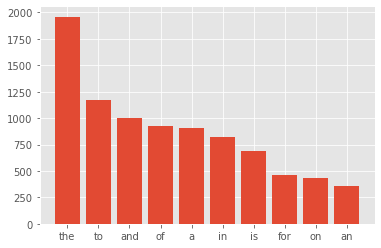

In [11]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 22 artists>

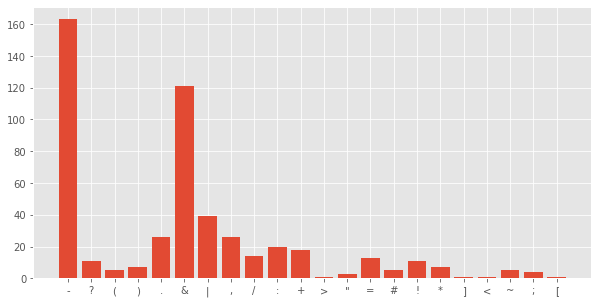

In [10]:
#test data
plt.figure(figsize=(10,5))
corpus=create_corpus()

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [12]:
#test data 
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

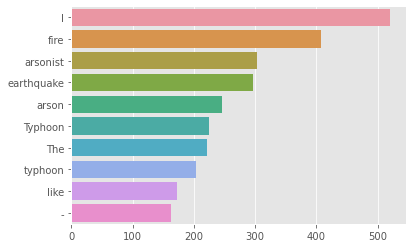

In [13]:
sns.barplot(x=y,y=x)

In [14]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

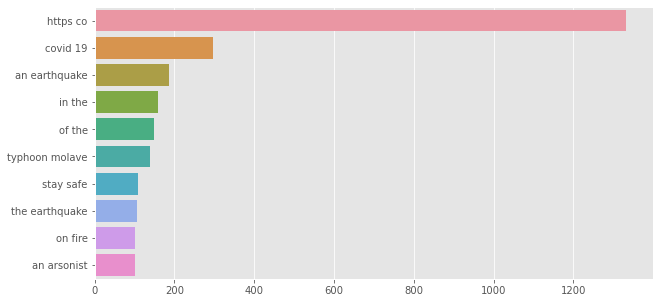

In [15]:
#test data
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(test['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [14]:
df=pd.concat([tweet,test])
df.shape

(10613, 5)

In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_URL(x))

In [16]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emoji(x))
test['text']=test['text'].apply(lambda x : remove_emoji(x))


In [17]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_html(x))

In [18]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))

In [19]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in tqdm(text.split()):
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        

#df['text'] = test['text'].apply(lambda x : correct_spellings(x))
test['text'] = test['text'].apply(lambda x : correct_spellings(x))

In [20]:
a = []
for i in df['text']:
    a.append(i)
print(a)

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask Canada', 'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected', '13000 people receive wildfires evacuation orders in California ', 'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ', 'RockyFire Update  California Hwy 20 closed in both directions due to Lake County fire  CAfire wildfires', 'flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas', 'Im on top of the hill and I can see a fire in the woods', 'Theres an emergency evacuation happening now in the building across the street', 'Im afraid that the tornado is coming to our area', 'Three people died from the heat wave so far', 'Haha South Tampa is getting flooded hah WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK flooding', 'raining flooding Flo

In [21]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [22]:
corpus=create_corpus(df)

100%|██████████| 10613/10613 [00:02<00:00, 5146.59it/s]


In [23]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [24]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20652


In [25]:
embedding_dict={}
with open('glove.6B.100d.txt','r',encoding="UTF-8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


In [29]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec


100%|██████████| 20652/20652 [00:00<00:00, 353388.27it/s]


In [30]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.046539    0.61966002  0.56647003 ... -0.37616    -0.032502
   0.80620003]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [-0.41055    -0.16583    -0.25112    ...  0.067104   -0.16716
   0.12425   ]
 [ 0.11952    -0.40967     0.063533   ...  0.15256999  0.22663
  -0.31672001]
 [ 0.32923999  0.92198998  0.71706998 ...  0.36061001  0.30926001
   0.015689  ]]


In [30]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [31]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [32]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [33]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 40s - loss: 0.6825 - accuracy: 0.5784 - val_loss: 0.5987 - val_accuracy: 0.6979
Epoch 2/15
1618/1618 - 40s - loss: 0.5769 - accuracy: 0.7333 - val_loss: 0.5223 - val_accuracy: 0.7890
Epoch 3/15
1618/1618 - 40s - loss: 0.5473 - accuracy: 0.7452 - val_loss: 0.4996 - val_accuracy: 0.7898
Epoch 4/15
1618/1618 - 40s - loss: 0.5217 - accuracy: 0.7606 - val_loss: 0.4842 - val_accuracy: 0.7890
Epoch 5/15
1618/1618 - 40s - loss: 0.5126 - accuracy: 0.7657 - val_loss: 0.4695 - val_accuracy: 0.7977
Epoch 6/15
1618/1618 - 41s - loss: 0.5036 - accuracy: 0.7713 - val_loss: 0.4615 - val_accuracy: 0.8030
Epoch 7/15
1618/1618 - 41s - loss: 0.4977 - accuracy: 0.7758 - val_loss: 0.4543 - val_accuracy: 0.8100
Epoch 8/15
1618/1618 - 41s - loss: 0.4900 - accuracy: 0.7813 - val_loss: 0.4490 - val_accuracy: 0.8135
Epoch 9/15
1618/1618 - 41s - loss: 0.4829 - accuracy: 0.7804 - val_loss: 0.4456 - val_accuracy: 0.8144
Epoch 10/15
1618/1618 - 41s - loss: 0.4883 - accuracy: 0.7767 - val_loss:

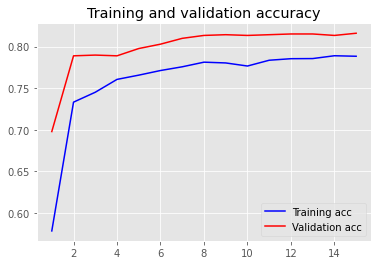

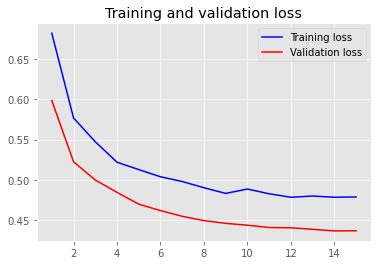

In [34]:
epochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()


In [35]:
sample_sub=pd.read_csv('test123.csv')


In [36]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3000)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [37]:
sub.head()

,id,target
0,1,0
1,2,1
2,3,1
3,4,0
4,5,0


Text(0, 0.5, 'samples')

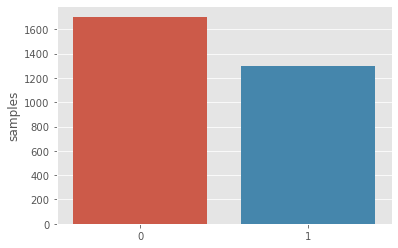

In [38]:
result=sub['target'].value_counts()
sns.barplot(result.index,result)
plt.gca().set_ylabel('samples')

In [39]:
from wordcloud import WordCloud, STOPWORDS
STOPWORDS.add('https')  # remove htps to the world Cloud
def Plot_world(text):    
    comment_words = ' '
    stopwords = set(STOPWORDS)   
    for val in text: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '
    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

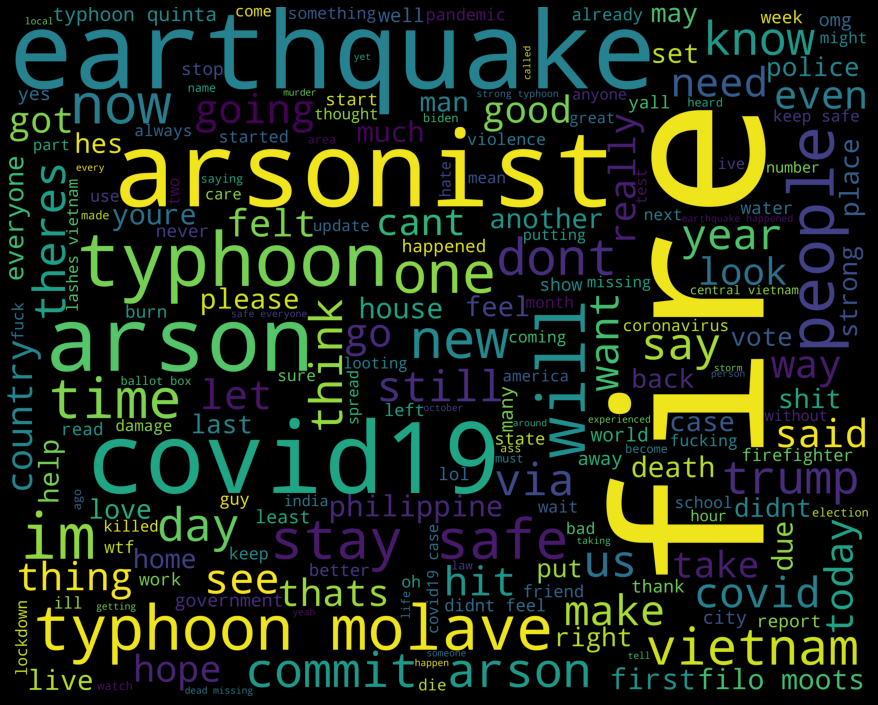

In [56]:
word = test.text
Plot_world(word)

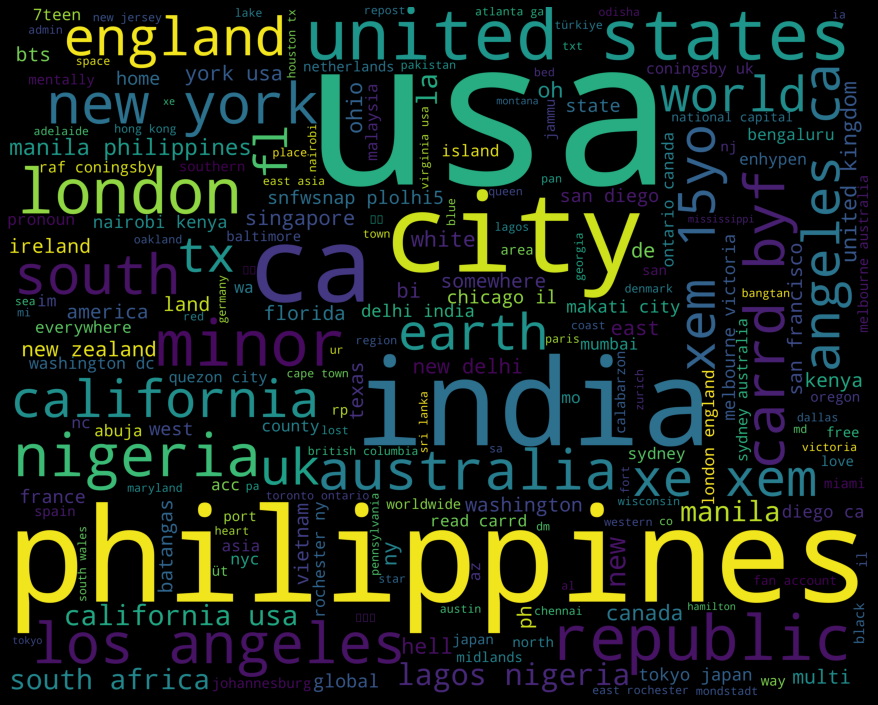

In [47]:

location_1 = sample_sub.location.dropna()

Plot_world(location_1)

In [41]:
mom=pd.merge(sub,sample_sub,on="id",how="left")
mom.head()

,id,target,keyword,location,text
0,1,0,typhoon,MISSISSIPPI,You cant help but be honest and opinionated wh...
1,2,1,earthquake,"💯personal, reikableu-all SNS",Was that my imagination only? Or was it an #ea...
2,3,1,arsonist,"Victoria, Australia","The time for fire reduction burns is limited, ..."
3,4,0,arson,"Washington, DC","No, we like arson"
4,5,0,earthquake,euphoria ♡,"yeah, I heard there was an earthquake but I di..."


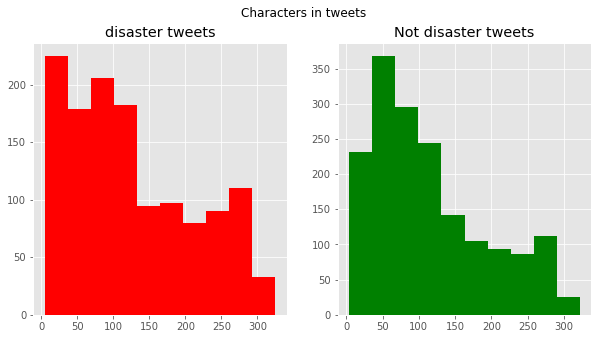

In [42]:
# the x axis is characters in a tweet, y-axis is how many tweets in those specific character numbers
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=mom[mom['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')

ax1.set_title('disaster tweets')
tweet_len=mom[mom['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')

ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

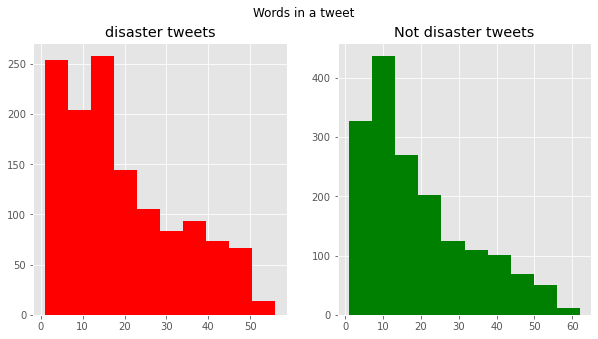

In [43]:
# the x axis is word in a tweet, y-axis is how many tweets in those specific word numbers
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=mom[mom['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=mom[mom['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')

plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

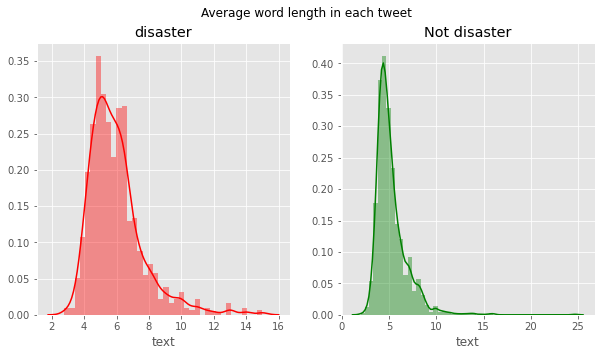

In [44]:
#test data
#Average word length in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=mom[mom['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=mom[mom['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')


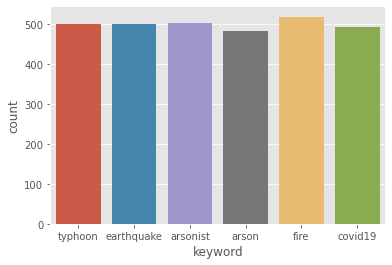

In [45]:
ax = sns.countplot(x="keyword", data=sample_sub)